In [12]:
#!pip install powerlaw==1.4.6
#!pip install sklearn
#!pip install -U scikit-learn
#!pip install pandas numpy seaborn matplotlib nltk powerlaw plotly




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Giova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from scipy.optimize import curve_fit
from sklearn import preprocessing
import networkx as nx
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
import itertools
import collections
import powerlaw
from nltk import bigrams
from nltk.util import ngrams
import os
import glob
import plotly.express as px
import plotly.graph_objs as go
from nltk.corpus import stopwords
import string
import math
# use glob to get all the csv files in the folder



In [14]:
df = pd.read_csv('df_tutti_1.csv')
df.shape

(53581, 30)

In [15]:
user=[]
for i in range(0, len(df['user'])):
    c=df['user'][i].split("'")
    user.append(c[3])
    
use = np.array(user) 
unique_user = np.unique(use)
len(unique_user)

men_user=[[] for _ in range(0,len(df['mentionedUsers']))]

for i in range(0,len(df['mentionedUsers'])):
    if isinstance(df['mentionedUsers'][i],float):
        men_user[i].append('nan')
    else:
        v=df['mentionedUsers'][i].split("{")
        v.remove(v[0])
        if len(v)>1:
            for j in range(0, len(v)-1):
                d=v[j].split("'")
                men_user[i].append(d[3])
        elif len(v)==1:
            d=v[0].split("'")
            men_user[i].append(d[3])
    
df.drop(df.columns.difference(['renderedContent']), axis=1, inplace=True)

df['user']=user
df['men_user']=men_user

df['Tweet'] = df['renderedContent']
df = df.drop('renderedContent', axis=1)

# remove words that start with '@'
df['Tweet'] = df['Tweet'].str.replace(r'@\w+', '', regex=True)    

In [16]:
# Create network plot
G = nx.Graph()

# Create connections between nodes
for k ,v ,m in zip(df['user'].items(),df['men_user'].items(),df['Tweet'].items()):
    for i in range(0, len(v[1])):
        if v[1][i]=='nan':pass
        else:  
            G.add_edge(k[1], v[1][i], tweet=m[1])        

(G.number_of_nodes(),G.number_of_edges())

(26429, 49998)

In [17]:
G.remove_edges_from(nx.selfloop_edges(G))
(G.number_of_nodes(),G.number_of_edges(),nx.density(G))

(26429, 49981, 0.00014311656620254626)

Link prediction

In [20]:
#!pip install linkpred

import linkpred

# Get the number of connected components in the graph
num_components = nx.number_connected_components(G)

print(f'The graph has {num_components} connected components.')

You should consider upgrading via the 'C:\Users\Giova\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


  Using cached linkpred-0.5.1.tar.gz (23 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached PyYAML-6.0-cp39-cp39-win_amd64.whl (151 kB)
  Using cached smokesignal-0.7.0.tar.gz (5.9 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for linkpred, since package 'wheel' is not installed.
Using legacy 'setup.py install' for smokesignal, since package 'wheel' is not installed.
  Running setup.py install for smokesignal: started
  Running setup.py install for smokesignal: finished with status 'done'
  Running setup.py install for linkpred: started
  Running setup.py install for linkpred: finished with status 'done'
The graph has 1682 connected components.


In [14]:
# Create a new graph containing only nodes with degree >= 5
useful_nodes = [n for n, d in G.degree() if d >= 5]

H = G.subgraph(useful_nodes)

# Get the number of connected components in the sub graph
num_components = nx.number_connected_components(H)

print(f'The graph has {num_components} connected components.')

The graph has 71 connected components.


Common Neighbors

The more friends we share, the more likely we will become friends.

In [234]:
cn = linkpred.predictors.CommonNeighbours(H, excluded= H.edges()) # We aim to predict only new links, thus we exclude existing ones
cn_results = cn.predict()


In [237]:
top = cn_results.top(100)
for edge, score in top.items():
    print(edge, score)


CarloCalenda - Azione_it 434.0
ItaliaViva - Azione_it 345.0
GiorgiaMeloni - FratellidItalia 336.0
ItaliaViva - CarloCalenda 265.0
matteorenzi - CarloCalenda 258.0
matteorenzi - Azione_it 209.0
matteorenzi - ItaliaViva 206.0
pdnetwork - EnricoLetta 190.0
EnricoLetta - CarloCalenda 171.0
mara_carfagna - CarloCalenda 168.0
GiorgiaMeloni - CarloCalenda 168.0
FratellidItalia - CarloCalenda 157.0
pdnetwork - CarloCalenda 151.0
meb - ItaliaViva 145.0
meb - Azione_it 136.0
FratellidItalia - Azione_it 125.0
LegaSalvini - FratellidItalia 124.0
GiorgiaMeloni - Azione_it 123.0
GiorgiaMeloni - EnricoLetta 119.0
pdnetwork - Azione_it 110.0
matteorenzi - EnricoLetta 104.0
GiuseppeConteIT - CarloCalenda 102.0
FratellidItalia - EnricoLetta 98.0
pdnetwork - FratellidItalia 97.0
msgelmini - CarloCalenda 94.0
meb - CarloCalenda 94.0
EnricoLetta - Azione_it 93.0
ItaliaViva - FratellidItalia 90.0
elenabonetti - ItaliaViva 89.0
LegaSalvini - GiorgiaMeloni 88.0
elenabonetti - Azione_it 86.0
matteosalvinimi - 


Jaccard

The more similar our friends circles are, the more likely we will become friends.


In [164]:
jc = linkpred.predictors.Jaccard(H, excluded=H.edges())
jc_results = jc.predict()


In [165]:
top = jc_results.top(15)
for edge, score in top.items():
    print(edge, score)



super_caz - Eva23344938 1.0
sergio_troise - Nicco60976267 1.0
sergio_troise - IlGrandinato 1.0
sergio_troise - Dir_Fontana 1.0
sergio_troise - 65_stark 1.0
sampeimuja - fai_tardi 1.0
sampeimuja - best40717405 1.0
sampeimuja - Tiziana13387032 1.0
sampeimuja - FattoreOscuro 1.0
sampeimuja - Alfredo_easy 1.0
rudi_lunardi - Zizouzidane77 1.0
rossodisera14 - danielelozzi 1.0
robertorru1 - moro_thomas 1.0
robertorru1 - mauriziobaff 1.0
robertorru1 - giuseppebasile2 1.0



Adamic Adar

The more selective our mutual friends are, the more likely we will become friends.


In [ ]:
aa = linkpred.predictors.AdamicAdar(H, excluded=H.edges())
aa_results = aa.predict()

top = aa_results.top(50)
for edge, score in top.items():
    print(edge, score)

In [ ]:
# katz
# Katz computes the weighted sum over all the paths between two nodes.


kz = linkpred.predictors.Katz(H, excluded=H.edges())
kz_results = kz.predict()

top = kz_results.top(15)
for edge, score in top.items():
    print(edge, score)


In [245]:
net_basic_info(g)


- Numero Nodi: 299
- Numero Edges: 5413
- Numero di self-loop:  0
- La rete e' diretta: False
- Numero massimo di collegamenti (L_max): 44551.0
- Avarage Degree: 36.207357859531776


In [247]:
simrank = linkpred.predictors.SimRank(H, excluded=H.edges())
simrank_results = simrank.predict(c=0.5)

top = simrank_results.top(100)
for edge, score in top.items():
    print(edge, score)



rossodisera14 - danielelozzi 0.5000017488247729
TheGuru00169880 - MastinoAlfredo 0.5000017482060317
LiefLayer - Beverari_M 0.5000017481896784
sscnapoli - acmilan 0.2982925982041459
acmilan - Inter 0.29524078829285905
marcoazzi66 - RossoneroKonic 0.28022978230439965
TommasoCristia3 - Lorenzo11122 0.27289908895230963
hortominnesota - Bonu4L 0.27147746484334667
hortominnesota - FGiallorossa 0.2714774642912254
marifcinter - SorellaBaderla 0.26944608873818016
Sir_C4T - GoProjectSrl 0.26875332667569934
marcoazzi66 - GoProjectSrl 0.26875332430672433
juanito92x - AIA_it 0.26757096257237506
Jesus66253584 - CleliaMussari 0.2629741438073819
guidotolomei - DomenixJuve1095 0.26190245225314657
EdoardoMecca1 - ColpogobboYtube 0.26113293567703605
juanito92x - EdoardoMecca1 0.2611329351250469
juanito92x - MarcelloChirico 0.25857271043127517
giungla87 - bloccatoseriale 0.25538120183445706
laltrodiego - Beaoh11 0.2550630125147169
SorellaBaderla - RiccardoValassi 0.25478758948023655
pollon_anna - lacramio

In [5]:
def net_basic_info(g):
    nodes = g.number_of_nodes()
    edges = g.number_of_edges()
    directness = g.is_directed()
    self_loops = nx.number_of_selfloops(g)
    lMax = ((nodes) * (nodes - 1)) / 2
    AvgDegree = sum(dict(g.degree()).values())/float(len(g))

    print('- Numero Nodi:', nodes)
    print('- Numero Edges:', edges)
    print ("- Numero di self-loop: ", self_loops)
    print("- La rete e' diretta:",directness)
    print('- Numero massimo di collegamenti (L_max):', lMax)
    print('- Avarage Degree:', AvgDegree)

In [ ]:
def read_net_w(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[0], l[1], weight=int(l[2]))
    return g
        

In [240]:
# Political election data
g = read_net_w(f'edge_weights.csv')

Creating smaller dataset

In [230]:
# Create a new graph containing only nodes with degree >= 5
useful_nodes = [n for n, d in g.degree() if d >= 60]

g = g.subgraph(useful_nodes)

# Get the number of connected components in the sub graph
num_components = nx.number_connected_components(g)

print(f'The graph has {num_components} connected components.')


The graph has 0 connected components.


In [218]:
net_basic_info(g)


- Numero Nodi: 53
- Numero Edges: 551
- Numero di self-loop:  0
- La rete e' diretta: False
- Numero massimo di collegamenti (L_max): 1378.0
- Avarage Degree: 20.79245283018868


In [186]:
# create a test graph
df = pd.read_csv('df_tutti_2.csv')


user=[]
for i in range(0, len(df['user'])):
    c=df['user'][i].split("'")
    user.append(c[3])
    
use = np.array(user) 
unique_user = np.unique(use)
len(unique_user)

men_user=[[] for _ in range(0,len(df['mentionedUsers']))]

for i in range(0,len(df['mentionedUsers'])):
    if isinstance(df['mentionedUsers'][i],float):
        men_user[i].append('nan')
    else:
        v=df['mentionedUsers'][i].split("{")
        v.remove(v[0])
        if len(v)>1:
            for j in range(0, len(v)-1):
                d=v[j].split("'")
                men_user[i].append(d[3])
        elif len(v)==1:
            d=v[0].split("'")
            men_user[i].append(d[3])
    
df.drop(df.columns.difference(['renderedContent']), axis=1, inplace=True)

df['user']=user
df['men_user']=men_user

df['Tweet'] = df['renderedContent']
df = df.drop('renderedContent', axis=1)

# remove words that start with '@'
df['Tweet'] = df['Tweet'].str.replace(r'@\w+', '', regex=True)  


# Create empty graph
t = nx.Graph()

# Iterate through rows of dataframe
for _, row in df.iterrows():
    user = row['user']
    men_users = row['men_user']
    tweet = row['Tweet']
    
    # Add nodes to graph if they don't already exist
    if not t.has_node(user):
        t.add_node(user)
    
    for pair in itertools.combinations(men_users, 2):
        if not t.has_edge(*pair):
            # If edge does not exist, add with weight 1 and tweet attribute
            t.add_edge(*pair, weight=1, tweet=[tweet])
        else:
            # If edge already exists, increment weight by 1 and append tweet attribute
            t.edges[pair]['weight'] += 1
            t.edges[pair]['tweet'].append(tweet)

In [191]:
net_basic_info(t)

- Numero Nodi: 31415
- Numero Edges: 31541
- Numero di self-loop:  0
- La rete e' diretta: False
- Numero massimo di collegamenti (L_max): 493435405.0
- Avarage Degree: 2.008021645710648


In [188]:
#remove self loop
t.remove_edges_from(nx.selfloop_edges(t))

In [213]:
import random
import itertools
from linkpred.evaluation import Pair


# taking nodes only with degree >= 10 (a smaller one)
useful_nodes = [n for n, d in t.degree() if d >= 100]

test = t.subgraph(useful_nodes)

net_basic_info(test)

- Numero Nodi: 33
- Numero Edges: 383
- Numero di self-loop:  0
- La rete e' diretta: False
- Numero massimo di collegamenti (L_max): 528.0
- Avarage Degree: 23.21212121212121


In [219]:
# Exclude test network from learning phase
training = g.copy()


# Node set
nodes = list(g.nodes())
nodes.extend(list(test.nodes()))

In [220]:
# Compute the test set and the universe set
test = [Pair(i) for i in test.edges()]
universe = set([Pair(i) for i in itertools.product(nodes, nodes) if i[0]!=i[1]])

In [221]:
import linkpred

cn = linkpred.predictors.CommonNeighbours(training, excluded=training.edges())
cn_results = cn.predict()

aa = linkpred.predictors.AdamicAdar(training, excluded=training.edges())
aa_results = aa.predict()

jc = linkpred.predictors.Jaccard(training, excluded=training.edges())
jc_results = jc.predict()


jc_evaluation = linkpred.evaluation.EvaluationSheet(jc_results, test, universe)
cn_evaluation = linkpred.evaluation.EvaluationSheet(cn_results, test, universe)
aa_evaluation = linkpred.evaluation.EvaluationSheet(aa_results, test, universe)

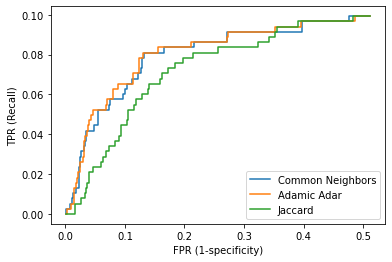

Area Under Roc Curve (AUROC)
Common Neigh.: 	 0.04045265979181528
Adamic Adar: 	 0.040920140451967235
Jaccard: 	 0.036532747885948576


In [222]:
plt.plot(cn_evaluation.fallout(), cn_evaluation.recall(), label="Common Neighbors")
plt.plot(aa_evaluation.fallout(), aa_evaluation.recall(), label="Adamic Adar")
plt.plot(jc_evaluation.fallout(), jc_evaluation.recall(), label="Jaccard")
plt.ylabel("TPR (Recall)")
plt.xlabel("FPR (1-specificity)")
plt.legend()
plt.show()

from sklearn.metrics import auc

print("Area Under Roc Curve (AUROC)")
print(f"Common Neigh.: \t {auc(cn_evaluation.fallout(), cn_evaluation.recall())}")
print(f"Adamic Adar: \t {auc(aa_evaluation.fallout(), aa_evaluation.recall())}")
print(f"Jaccard: \t {auc(jc_evaluation.fallout(), jc_evaluation.recall())}")

In [ ]:
print("Area Under Roc Curve (AUROC)")
print(f"Common Neigh.: \t {auc(cn_evaluation.fallout(), cn_evaluation.recall())}")
print(f"Adamic Adar: \t {auc(aa_evaluation.fallout(), aa_evaluation.recall())}")
print(f"Jaccard: \t {auc(jc_evaluation.fallout(), jc_evaluation.recall())}")
print(f"SimRank: \t {auc(sm_evaluation.fallout(), sm_evaluation.recall())}")
print(f"Katz:\t \t {auc(kz_evaluation.fallout(), kz_evaluation.recall())}")

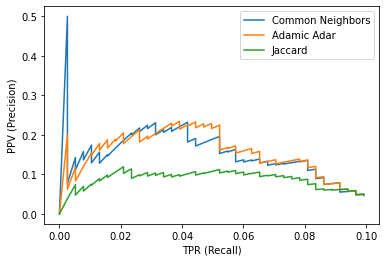

In [223]:
plt.plot( cn_evaluation.recall(), cn_evaluation.precision() , label="Common Neighbors")
plt.plot( aa_evaluation.recall(), aa_evaluation.precision() , label="Adamic Adar")
plt.plot( jc_evaluation.recall(), jc_evaluation.precision() , label="Jaccard")
plt.xlabel("TPR (Recall)")
plt.ylabel("PPV (Precision)")
plt.legend()
plt.show()


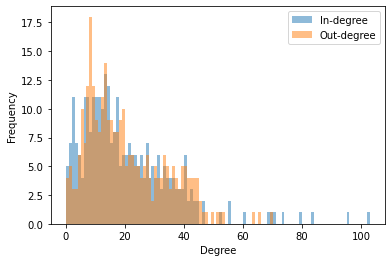

In [198]:
# Calculate the in-degree and out-degree distributions
in_degree = dict(g_dir.in_degree())
out_degree = dict(g_dir.out_degree())


# Sort the degree values in decreasing order
in_degree = {k: v for k, v in sorted(in_degree.items(), key=lambda item: item[1], reverse=True)}
out_degree = {k: v for k, v in sorted(out_degree.items(), key=lambda item: item[1], reverse=True)}

# Plot the in-degree distribution
plt.hist(list(in_degree.values()), bins=range(max(in_degree.values())+2), alpha=0.5, label='In-degree')

# Plot the out-degree distribution
plt.hist(list(out_degree.values()), bins=range(max(out_degree.values())+2), alpha=0.5, label='Out-degree')

# Add labels and legend
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

In [255]:
#preds = list(nx.preferential_attachment(training,list(training.edges())))
preds = list(nx.preferential_attachment(H))
pref_results=[]
for u, v, p in preds:
    #print('(%s, %s) -> %d' % (u, v, p))
    pref_results.append([u,v,p])
pref_results=sorted(pref_results,key=lambda x: x[2],reverse=True)
pref_results

[['Azione_it', 'CarloCalenda', 647666],
 ['FratellidItalia', 'CarloCalenda', 581216],
 ['GiorgiaMeloni', 'CarloCalenda', 567040],
 ['FratellidItalia', 'Azione_it', 479536],
 ['Azione_it', 'GiorgiaMeloni', 467840],
 ['CarloCalenda', 'ItaliaViva', 443000],
 ['EnricoLetta', 'CarloCalenda', 426166],
 ['FratellidItalia', 'GiorgiaMeloni', 419840],
 ['pdnetwork', 'CarloCalenda', 393384],
 ['CarloCalenda', 'matteorenzi', 386296],
 ['Azione_it', 'ItaliaViva', 365500],
 ['EnricoLetta', 'Azione_it', 351611],
 ['FratellidItalia', 'ItaliaViva', 328000],
 ['Azione_it', 'pdnetwork', 324564],
 ['GiorgiaMeloni', 'ItaliaViva', 320000],
 ['Azione_it', 'matteorenzi', 318716],
 ['EnricoLetta', 'FratellidItalia', 315536],
 ['EnricoLetta', 'GiorgiaMeloni', 307840],
 ['FratellidItalia', 'pdnetwork', 291264],
 ['FratellidItalia', 'matteorenzi', 286016],
 ['pdnetwork', 'GiorgiaMeloni', 284160],
 ['GiorgiaMeloni', 'matteorenzi', 279040],
 ['EnricoLetta', 'ItaliaViva', 240500],
 ['GiuseppeConteIT', 'CarloCalenda'

In [256]:
type(pref_results)

list